In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../data/spotify_refined.csv", index_col=0)

rows_count = data.shape[0]

data.head()

duration_ms  key  mode  time_signature  energy  valence  instrumentalness  \
0       204600    2     1             4.0   0.434    0.286          0.021900   
1       326933    1     1             4.0   0.359    0.588          0.006110   
2       185707    2     1             4.0   0.412    0.173          0.000234   
3       199413    5     1             4.0   0.338    0.230          0.510000   
4       392893    5     0             4.0   0.561    0.904          0.512000   

     tempo  loudness  
0  150.062    -8.795  
1  160.083   -10.401  
2   75.044    -7.148  
3   86.468   -15.236  
4  174.004   -11.648

# Feature selection

In [3]:
def show_column_histogram(data, column_idx, bins_count=40):
    column_name = data.columns[column_idx]
    plt.hist(data.values[:, column_idx], bins=bins_count)
    plt.title(
        f"Histogram of {column_name}" 
        f" with {bins_count} bins"
    )
    plt.show()

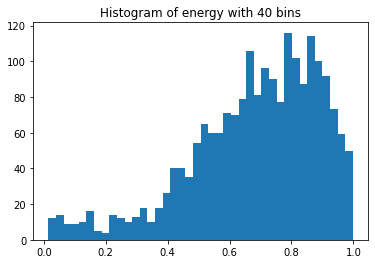

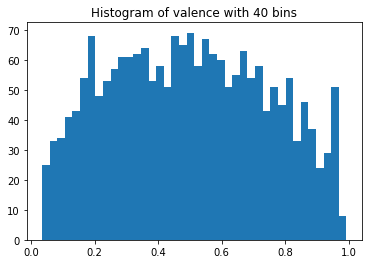

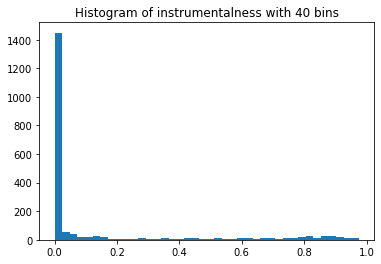

In [4]:
for column_idx in range(len(data.columns)):
    if data.dtypes[column_idx] == 'object':
        continue
    
    show_column_histogram(data, column_idx)

Selected features: duration_ms, energy, tempo

In [5]:
selected_data = data[["duration_ms", "energy", "tempo"]]

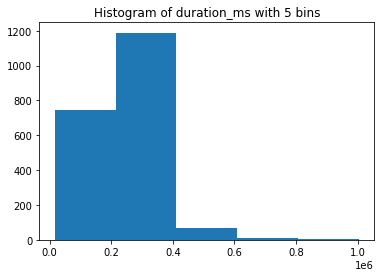

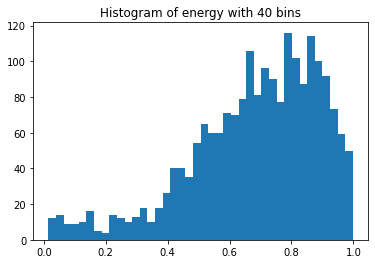

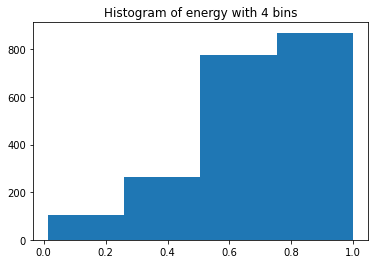

In [6]:
bins_count = {"duration_ms": 5, "energy": 4, "tempo": 6}

for column_idx, column_name in enumerate(selected_data.columns):
    show_column_histogram(selected_data, column_idx, bins_count=40)
    
    show_column_histogram(selected_data, column_idx, bins_count=bins_count[column_name])
    

In [7]:
feature_segments = {
    "duration_ms": [0, 150000, 220000, 350000, 400000, 1500000],
    "energy": [0, 0.4, 0.6, 0.8, 1.0] ,
    "tempo": [0, 75, 100, 125, 150, 175, 225],
}

data_values = selected_data.values

for row in range(data_values.shape[0]):
    for column_idx in range(data_values.shape[1]):
        value = data_values[row, column_idx]
        
        for nominal_value, segment_right_bound in enumerate(
            feature_segments[selected_data.columns[column_idx]][1:]
        ):
            if value <= segment_right_bound:
                data_values[row, column_idx] = nominal_value + 1
                
                # print(nominal_value, row, column_idx)
                
                break

In [8]:
nominal_data = pd.DataFrame(data_values, columns = [
    'duration_ms (nominal)',
    'energy (nominal)',
    'tempo (nominal)'
])

nominal_data = nominal_data.astype(int)
            
nominal_data.head()

duration_ms (nominal)  energy (nominal)  tempo (nominal)
0                      2                 2                5
1                      3                 1                5
2                      2                 2                2
3                      2                 1                2
4                      4                 2                5

# Contigency tables

In [9]:
def create_contingency_table(values_1, values_2):
    assert(len(values_1) == len(values_2))
    unique_values_1, unique_values_indexes_1 = np.unique(values_1, return_inverse=True)
    unique_values_2, unique_values_indexes_2 = np.unique(values_2, return_inverse=True)
    
    unique_values_count_1 = len(unique_values_1)
    unique_values_count_2 = len(unique_values_2)
    
    contingency_table = np.zeros((unique_values_count_1 + 1, unique_values_count_2 + 1))
    total_count = 0
    
    for row_id, unique_value_1 in enumerate(unique_values_1):
        for col_id, unique_value_2 in enumerate(unique_values_2):            
            table_value = 0
            
            for i in range(len(values_1)):
                if values_1[i] == unique_value_1 and values_2[i] == unique_value_2:
                    table_value += 1
                    
            contingency_table[row_id, col_id] = table_value
            total_count += table_value
            
        contingency_table[row_id, -1] = np.sum(contingency_table[row_id, :])

    contingency_table[-1, :] = np.sum(contingency_table, axis=0)
            
    frequencies = np.divide(contingency_table, total_count)
    
    contingency_table = contingency_table.astype(np.int32)
    
    return contingency_table, frequencies

In [10]:
np.set_printoptions(formatter={"float_kind": lambda x: f'{x:8.3f}'})

A = duration_ms(nominal)

B = energy(nominal)

C = tempo(nominal)

### Create tables

**P(C | A)**

In [11]:
contingency_table_CA, frequencies_CA = create_contingency_table(
    nominal_data["tempo (nominal)"].values,
    nominal_data["duration_ms (nominal)"].values
)

print("Contingency table C | A: \n", contingency_table_CA)
print("Frequencies C | A: \n", frequencies_CA)

Contingency table C | A: 
 [[   3   10   17    1    4   35]
 [  17  179  224   10   15  445]
 [  21  223  330   37   52  663]
 [  20  252  284   15   20  591]
 [   6   85  110    4    1  206]
 [   5   33   37    2    0   77]
 [  72  782 1002   69   92 2017]]
Frequencies C | A: 
 [[   0.001    0.005    0.008    0.000    0.002    0.017]
 [   0.008    0.089    0.111    0.005    0.007    0.221]
 [   0.010    0.111    0.164    0.018    0.026    0.329]
 [   0.010    0.125    0.141    0.007    0.010    0.293]
 [   0.003    0.042    0.055    0.002    0.000    0.102]
 [   0.002    0.016    0.018    0.001    0.000    0.038]
 [   0.036    0.388    0.497    0.034    0.046    1.000]]


**P(C | B)**

In [12]:
contingency_table_CB, frequencies_CB = create_contingency_table(
    nominal_data["tempo (nominal)"].values,
    nominal_data["energy (nominal)"].values
)

print("Contingency table C | B: \n", contingency_table_CB)
print("Frequencies C | B: \n", frequencies_CB)

Contingency table C | B: 
 [[  16    7   10    2   35]
 [  49  115  174  107  445]
 [  68  141  224  230  663]
 [  35  113  217  226  591]
 [  10   38   65   93  206]
 [   9    8   33   27   77]
 [ 187  422  723  685 2017]]
Frequencies C | B: 
 [[   0.008    0.003    0.005    0.001    0.017]
 [   0.024    0.057    0.086    0.053    0.221]
 [   0.034    0.070    0.111    0.114    0.329]
 [   0.017    0.056    0.108    0.112    0.293]
 [   0.005    0.019    0.032    0.046    0.102]
 [   0.004    0.004    0.016    0.013    0.038]
 [   0.093    0.209    0.358    0.340    1.000]]


### Joint and marginal frequencies

In [13]:
joint_freq_CA = contingency_table_CA[:-1, :-1]
joint_freq_CB = contingency_table_CB[:-1, :-1]

marginal_freq_C = contingency_table_CA[:-1, -1]
marginal_freq_A = contingency_table_CA[-1, :-1]
marginal_freq_B = contingency_table_CB[-1, :-1]

### Conditional tables

In [14]:
conditional_CA = np.divide(joint_freq_CA, marginal_freq_A)

print(f'Conditional C given A: \n {conditional_CA}')

Conditional C given A: 
 [[   0.042    0.013    0.017    0.014    0.043]
 [   0.236    0.229    0.224    0.145    0.163]
 [   0.292    0.285    0.329    0.536    0.565]
 [   0.278    0.322    0.283    0.217    0.217]
 [   0.083    0.109    0.110    0.058    0.011]
 [   0.069    0.042    0.037    0.029    0.000]]


In [15]:
conditional_CB = np.divide(joint_freq_CB, marginal_freq_B)

print(f'Conditional C given B: \n {conditional_CB}')

Conditional C given B: 
 [[   0.086    0.017    0.014    0.003]
 [   0.262    0.273    0.241    0.156]
 [   0.364    0.334    0.310    0.336]
 [   0.187    0.268    0.300    0.330]
 [   0.053    0.090    0.090    0.136]
 [   0.048    0.019    0.046    0.039]]


### Quetelet index

In [16]:
quetelet_CA = np.subtract(np.divide(conditional_CA, 
                                    marginal_freq_C.reshape(-1, 1) / rows_count), 1)
print(f"Quetelet index CA: \n{quetelet_CA}") 

Quetelet index CA: 
[[   1.401   -0.263   -0.022   -0.165    1.506]
 [   0.070    0.038    0.013   -0.343   -0.261]
 [  -0.113   -0.132    0.002    0.631    0.720]
 [  -0.052    0.100   -0.033   -0.258   -0.258]
 [  -0.184    0.064    0.075   -0.432   -0.894]
 [   0.819    0.105   -0.033   -0.241   -1.000]]


In [17]:
quetelet_CB = np.subtract(np.divide(conditional_CB, 
                                    marginal_freq_C.reshape(-1, 1) / rows_count), 1)
print(f'Quetelet index CB: \n{quetelet_CB}') 

Quetelet index CB: 
[[   3.931   -0.044   -0.203   -0.832]
 [   0.188    0.235    0.091   -0.292]
 [   0.106    0.016   -0.057    0.021]
 [  -0.361   -0.086    0.024    0.126]
 [  -0.476   -0.118   -0.120    0.329]
 [   0.261   -0.503    0.196    0.032]]


### Compute chi-squared

In [18]:
def compute_chi_squared(frequencies, independent_prob):
    frequencies = frequencies[:-1, :-1]
    tmp = np.power(np.subtract(frequencies, independent_prob), 2)
    
    return np.sum(np.divide(tmp, independent_prob))

In [19]:
independent_prob_CA = np.dot(marginal_freq_C.reshape(-1, 1) / rows_count, marginal_freq_A.reshape(1, -1) / rows_count)
independent_prob_CB = np.dot(marginal_freq_C.reshape(-1, 1) / rows_count, marginal_freq_B.reshape(1, -1) / rows_count)

In [20]:
average_quetelet_index_CA = np.sum(frequencies_CA[:-1, :-1].reshape(1, -1) * quetelet_CA.reshape(1, -1))

print(f"Average Quetelet Index C given A: \n{average_quetelet_index_CA:.3f}")



chi_squared_CA = compute_chi_squared(frequencies_CA, independent_prob_CA)

print(f"Chi-squared: {chi_squared_CA:.3f}")

Average Quetelet Index C given A: 
0.031
Chi-squared: 0.031


In [21]:
average_quetelet_index_CB = np.sum(frequencies_CB[:-1, :-1].reshape(1, -1) * quetelet_CB.reshape(1, -1))

print(f"Average Quetelet Index C given B: \n{average_quetelet_index_CB:.3f}")



chi_squared_CB = compute_chi_squared(frequencies_CB, independent_prob_CB)

print(f"Chi-squared: {chi_squared_CB:.3f}")

Average Quetelet Index C given B: 
0.055
Chi-squared: 0.055


In [22]:
print(f'{rows_count=}')
print()
print(f"{rows_count * chi_squared_CA=:.3f}")
print(f"{rows_count * chi_squared_CB=:.3f}")

rows_count=2017

rows_count * chi_squared_CA=61.744
rows_count * chi_squared_CB=111.930


# Visualization

In [23]:
heat_map_quet_CA = (frequencies_CA[:-1, :-1].reshape(1, -1) * quetelet_CA.reshape(1, -1)).reshape(6, 5)

print(f"Heat map Quetlete Index C given A: \n{heat_map_quet_CA}")

Heat map Quetlete Index C given A: 
[[   0.002   -0.001   -0.000   -0.000    0.003]
 [   0.001    0.003    0.001   -0.002   -0.002]
 [  -0.001   -0.015    0.000    0.012    0.019]
 [  -0.001    0.012   -0.005   -0.002   -0.003]
 [  -0.001    0.003    0.004   -0.001   -0.000]
 [   0.002    0.002   -0.001   -0.000   -0.000]]


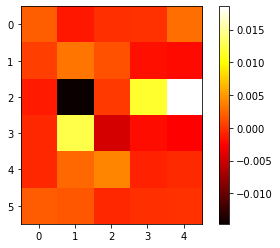

In [24]:
plt.imshow(heat_map_quet_CA, cmap='hot', 
           interpolation='nearest')
plt.colorbar()
plt.show()

In [25]:
heat_map_quet_CB = (frequencies_CB[:-1, :-1].reshape(1, -1) * quetelet_CB.reshape(1, -1)).reshape(6, 4)

print(f"Heat map Quetlete Index C given B: \n{heat_map_quet_CB}")

Heat map Quetlete Index C given B: 
[[   0.031   -0.000   -0.001   -0.001]
 [   0.005    0.013    0.008   -0.015]
 [   0.004    0.001   -0.006    0.002]
 [  -0.006   -0.005    0.003    0.014]
 [  -0.002   -0.002   -0.004    0.015]
 [   0.001   -0.002    0.003    0.000]]


In [26]:
plt.imshow(heat_map_quet_CB, cmap='hot', 
           interpolation='nearest')
plt.colorbar()
plt.show()